In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set(rc={'figure.figsize': (9, 6)})

In [4]:
events_data = pd.read_csv('event_data_train.csv')

In [5]:
submissions_data = pd.read_csv('submissions_data_train.csv')

In [6]:
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [7]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [8]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


# Convert timestamp to datetime, make features date and day

In [9]:
submissions_data['date'] = pd.to_datetime(submissions_data['timestamp'], unit='s')
submissions_data['day'] = submissions_data.date.dt.date

In [10]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [11]:
events_data['date'] = pd.to_datetime(events_data['timestamp'], unit='s')

In [12]:
events_data['day'] = events_data.date.dt.date

In [13]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [14]:
events_data.date.max()

Timestamp('2018-05-19 23:33:31')

In [15]:
events_data.date.min()

Timestamp('2015-06-15 04:00:48')

<AxesSubplot: xlabel='day'>

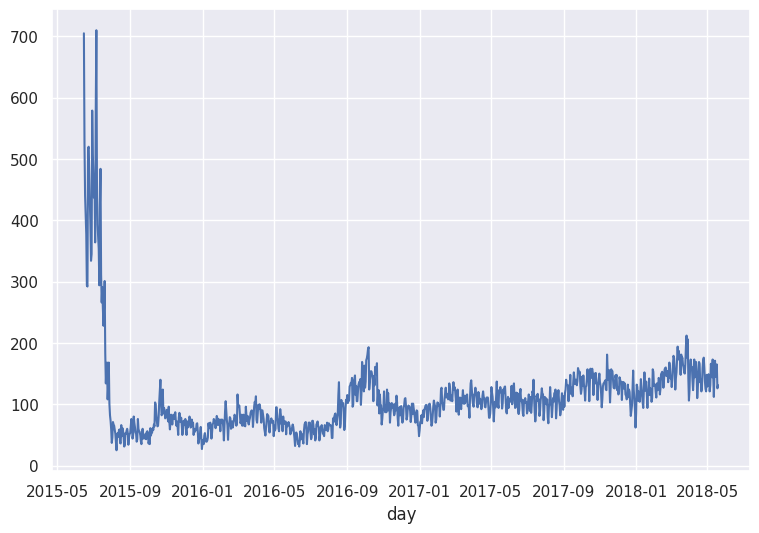

In [16]:
events_data.groupby('day') \
    .user_id.nunique() \
    .plot()

# Make pivot tables for actions in events_data and submisson status in submission_data

In [17]:
users_events_data = events_data.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

In [18]:
users_events_data

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1
...,...,...,...,...,...
19229,26790,8,8,1,9
19230,26793,1,0,1,1
19231,26794,69,69,34,180
19232,26797,10,10,2,13


In [19]:
users_scores = submissions_data.pivot_table(index='user_id', 
                        columns='submission_status', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

In [20]:
users_scores

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1
...,...,...,...
9935,26787,3,0
9936,26790,1,0
9937,26794,33,9
9938,26797,2,0


# Make gap_data - difference between observations

In [21]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values #разность между ближайшими наблюдениями

In [22]:
gap_data

array([array([], dtype=int64), array([4843602]),
       array([6899249,  182484,   93710, 2768870,  171400,   78712]), ...,
       array([   86128,   136759,    94899,  1422583, 14347289,   505061,
                 98252,    57019])                                       ,
       array([1567990]), array([], dtype=int64)], dtype=object)

In [23]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

In [24]:
gap_data

0         4843602
1         6899249
2          182484
3           93710
4         2768870
           ...   
97867    14347289
97868      505061
97869       98252
97870       57019
97871     1567990
Length: 97872, dtype: int64

In [25]:
gap_data = gap_data / (24 * 60 * 60)

In [26]:
gap_data

0         56.060208
1         79.852419
2          2.112083
3          1.084606
4         32.047106
            ...    
97867    166.056586
97868      5.845613
97869      1.137176
97870      0.659942
97871     18.148032
Length: 97872, dtype: float64

<AxesSubplot: >

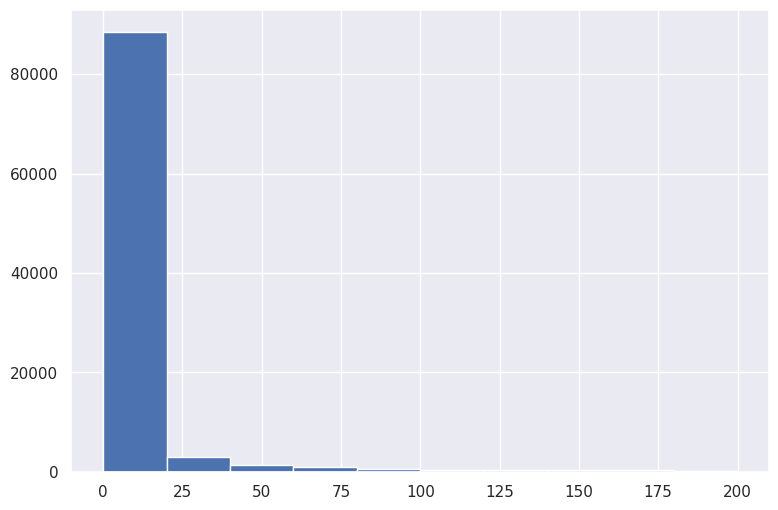

In [27]:
gap_data[gap_data < 200].hist()

# Find last timestamp for every user

In [28]:
events_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [29]:
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

In [30]:
users_data

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660
...,...,...
19229,26790,1517495987
19230,26793,1510225034
19231,26794,1512035039
19232,26797,1509995096


# User is gone if his last online was 30 days ago

In [31]:
now = 1526772811 # last observation
drop_out_treshold = 30 * 24 * 60 * 60 # our treshold is 30 days

In [32]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_treshold

In [33]:
users_data

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True
...,...,...,...
19229,26790,1517495987,True
19230,26793,1510225034,True
19231,26794,1512035039,True
19232,26797,1509995096,True


# Numbers of unique days when user was online

In [34]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [35]:
users_days

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1
...,...,...
19229,26790,4
19230,26793,1
19231,26794,9
19232,26797,2


# Merge users_scores, users_events_data and users_days to users_data

In [36]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')

In [37]:
users_data = users_data.fillna(0)

In [38]:
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0
...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0
19230,26793,1510225034,True,0.0,0.0
19231,26794,1512035039,True,33.0,9.0
19232,26797,1509995096,True,2.0,0.0


In [39]:
users_data = users_data.merge(users_events_data, how='outer')

In [40]:
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1
...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9
19230,26793,1510225034,True,0.0,0.0,1,0,1,1
19231,26794,1512035039,True,33.0,9.0,69,69,34,180
19232,26797,1509995096,True,2.0,0.0,10,10,2,13


In [41]:
users_data = users_data.merge(users_days, how='outer')

In [42]:
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2


In [43]:
users_data.user_id.nunique()

19234

In [44]:
events_data.user_id.nunique()

19234

# User did passed course if he passed more than 170 questions

In [45]:
users_data['passed_course'] = users_data.passed > 170

In [46]:
users_data.groupby('passed_course').count().user_id

passed_course
False    17809
True      1425
Name: user_id, dtype: int64

In [47]:
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False
...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4,False
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1,False
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9,False
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2,False


<AxesSubplot: >

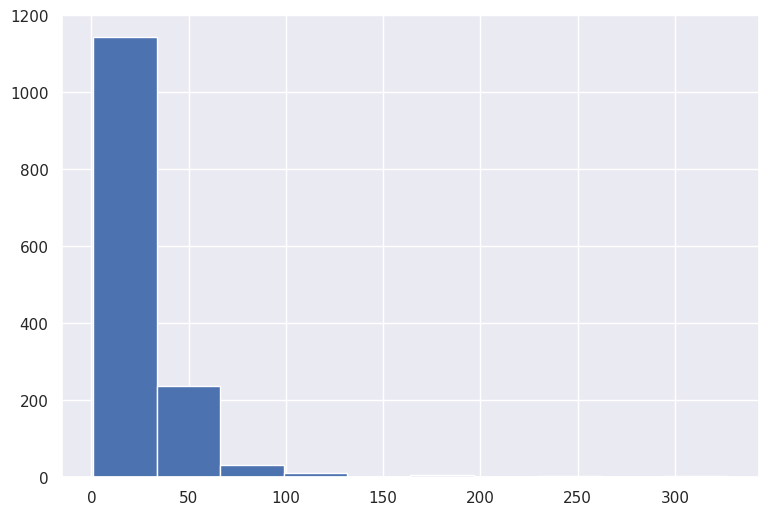

In [48]:
users_data[users_data.passed_course].day.hist()

# Min_timestamp for every user

In [49]:
user_min_time = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'min'}) \
    .rename({'timestamp': 'min_timestamp'}, axis=1)

In [50]:
user_min_time

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660
...,...,...
19229,26790,1451484016
19230,26793,1510225031
19231,26794,1495287049
19232,26797,1508425316


In [51]:
users_data = users_data.merge(user_min_time, how='outer')

In [52]:
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660
...,...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4,False,1451484016
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1,False,1510225031
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9,False,1495287049
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2,False,1508425316


# For every user calculate min_timestamp + 3 days

In [53]:
learning_time_treshold = 3 * 24 * 60 * 60
users_data['min+3days'] = users_data.min_timestamp + learning_time_treshold
users_data3 = users_data[['user_id', 'min+3days']]
users_data3

,user_id,min+3days
0,1,1473086664
1,2,1514642564
2,3,1434617676
3,5,1466416009
4,7,1521893860
...,...,...
19229,26790,1451743216
19230,26793,1510484231
19231,26794,1495546249
19232,26797,1508684516


# events_data_train - data for only 3 days

In [54]:
events_data_3 = events_data.merge(users_data3, on='user_id', how='outer')
events_data_train = events_data_3[events_data_3['timestamp'] < events_data_3['min+3days']]
events_data_train

,step_id,timestamp,action,user_id,date,day,min+3days
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434600048
...,...,...,...,...,...,...,...
3480698,32814,1526762783,discovered,943,2018-05-19 20:46:23,2018-05-19,1527021864
3480699,32814,1526762783,passed,943,2018-05-19 20:46:23,2018-05-19,1527021864
3480700,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,1527031950
3480701,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,1527031950


In [55]:
events_data_train.shape

(1014980, 7)

In [56]:
events_data.shape

(3480703, 6)

In [57]:
events_data_train.groupby('user_id').day.nunique().max()

4

# submissions_data_train - data for only 3 days

In [58]:
user_min_time['user_learning_time_threshold'] = user_min_time['min_timestamp'] + learning_time_treshold

In [59]:
user_min_time

,user_id,min_timestamp,user_learning_time_threshold
0,1,1472827464,1473086664
1,2,1514383364,1514642564
2,3,1434358476,1434617676
3,5,1466156809,1466416009
4,7,1521634660,1521893860
...,...,...,...
19229,26790,1451484016,1451743216
19230,26793,1510225031,1510484231
19231,26794,1495287049,1495546249
19232,26797,1508425316,1508684516


In [60]:
submissions_data

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15
...,...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47,2017-08-18
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06


In [61]:
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='left')

In [62]:
submissions_data_train = submissions_data[submissions_data['timestamp'] <= submissions_data['user_learning_time_threshold']]

In [63]:
submissions_data_train

,step_id,timestamp,submission_status,user_id,date,day,user_learning_time_threshold
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15,1434605177
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15,1434605177
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15,1434605177
5,31976,1434348188,correct,15853,2015-06-15 06:03:08,2015-06-15,1434605177
7,31977,1434347371,correct,15853,2015-06-15 05:49:31,2015-06-15,1434605177
...,...,...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05,1502205860
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47,2017-08-18,1503314487
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25,1506606463
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06,1523294469


In [64]:
submissions_data_train.groupby('user_id').day.nunique().max()

4

# Train set

In [65]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index() \
    .rename({'day': 'days'}, axis=1)

In [66]:
X

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3
...,...,...
8908,26787,1
8909,26790,1
8910,26794,3
8911,26797,1


In [67]:
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index() \
    .rename({'step_id': 'steps_tried'}, axis=1)

In [68]:
steps_tried

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,23
...,...,...
8908,26787,3
8909,26790,1
8910,26794,27
8911,26797,2


In [69]:
X = X.merge(steps_tried, on='user_id', how='outer')

In [70]:
X

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23
...,...,...,...
8908,26787,1,3
8909,26790,1,1
8910,26794,3,27
8911,26797,1,2


In [71]:
X = X.merge(submissions_data_train.pivot_table(index='user_id', 
                        columns='submission_status', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index())

In [72]:
X

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27
...,...,...,...,...,...
8908,26787,1,3,3,0
8909,26790,1,1,1,0
8910,26794,3,27,31,9
8911,26797,1,2,2,0


In [73]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [74]:
X

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.000000
1,3,1,4,4,4,0.500000
2,8,1,11,9,21,0.300000
3,14,1,1,0,1,0.000000
4,16,3,23,23,27,0.460000
...,...,...,...,...,...,...
8908,26787,1,3,3,0,1.000000
8909,26790,1,1,1,0,1.000000
8910,26794,3,27,31,9,0.775000
8911,26797,1,2,2,0,1.000000


In [75]:
X = X.merge(events_data_train.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

In [76]:
X = X.fillna(0)

In [77]:
X

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132
...,...,...,...,...,...,...,...
19229,26774,0.0,0.0,0.0,0.0,0.00,1
19230,26781,0.0,0.0,0.0,0.0,0.00,6
19231,26788,0.0,0.0,0.0,0.0,0.00,1
19232,26789,0.0,0.0,0.0,0.0,0.00,2


In [78]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], how='outer')

# User passed course or didn't pass and gone

In [79]:
X = X[~((X.is_gone_user == False) & (X.passed_course == False))]

In [80]:
X.groupby(['passed_course', 'is_gone_user']).user_id.count()

passed_course  is_gone_user
False          True            16560
True           False             141
               True             1284
Name: user_id, dtype: int64

In [81]:
y = X.passed_course.map(int)

In [82]:
X = X.drop(['passed_course', 'is_gone_user'], axis=1)

In [83]:
X = X.set_index('user_id')

In [84]:
X

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132
...,...,...,...,...,...,...
26774,0.0,0.0,0.0,0.0,0.00,1
26781,0.0,0.0,0.0,0.0,0.00,6
26788,0.0,0.0,0.0,0.0,0.00,1


# Decision Tree

In [86]:
from sklearn.model_selection import train_test_split
from sklearn import tree

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [88]:
clf = tree.DecisionTreeClassifier(criterion='entropy')

In [89]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [90]:
clf.score(X_train, y_train)

0.974022740476388

In [91]:
clf.score(X_test, y_test)

0.9066711590296496

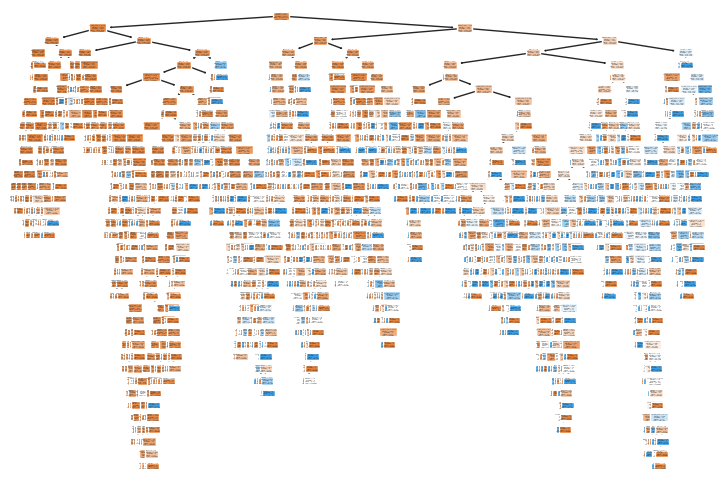

In [92]:
tree.plot_tree(clf, feature_names=list(X),
               class_names=['Dropped', 'Passed'],
               filled=True);

In [93]:
scores_data = pd.DataFrame()

In [98]:
for max_depth in range(1, 100):
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth = max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth], 
                                    'train_score': [train_score], 
                                    'test_score': [test_score]})
    
    scores_data = pd.concat([scores_data, temp_score_data])

In [99]:
scores_data

,max_depth,train_score,test_score
0,1,0.916757,0.928908
0,2,0.916757,0.928908
0,3,0.919412,0.928066
0,4,0.919578,0.927224
0,5,0.920740,0.927224
...,...,...,...
0,95,0.974023,0.905323
0,96,0.974023,0.904987
0,97,0.974023,0.906840
0,98,0.974023,0.906840


<AxesSubplot: xlabel='max_depth', ylabel='score'>

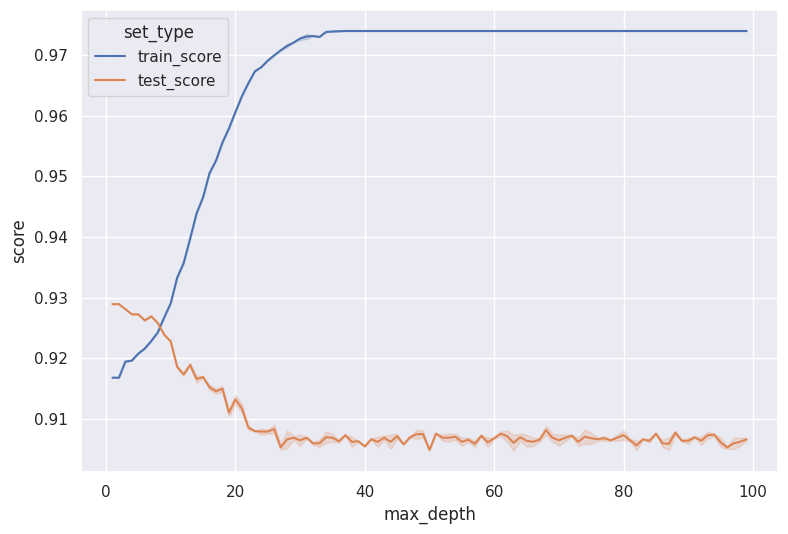

In [100]:
scores_data_long = pd.melt(scores_data, 
                           id_vars = ['max_depth'], 
                           value_vars = ['train_score','test_score'], 
                           var_name = 'set_type', 
                           value_name = 'score')

sns.lineplot(x='max_depth', y='score', hue='set_type', data=scores_data_long)

In [101]:
scores_data_long

,max_depth,set_type,score
0,1,train_score,0.916757
1,2,train_score,0.916757
2,3,train_score,0.919412
3,4,train_score,0.919578
4,5,train_score,0.920740
...,...,...,...
391,95,test_score,0.905323
392,96,test_score,0.904987
393,97,test_score,0.906840
394,98,test_score,0.906840


# Cross-validation

In [102]:
from sklearn.model_selection import cross_val_score

In [103]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 4)

In [104]:
cross_val_score(clf, X_train, y_train, cv=5)oss_val_score(clf, X_train, y_train, cv=5)

array([0.91452282, 0.91618257, 0.91950207, 0.9186722 , 0.91739311])

In [107]:
scores_data = pd.DataFrame()

In [108]:
for max_depth in range(1, 100):
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth = max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    
    mean_cross_val_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth], 
                                    'train_score': [train_score], 
                                    'test_score': [test_score],
                                    'cross_val_score': [mean_cross_val_score]})
    
    scores_data = pd.concat([scores_data, temp_score_data])

In [109]:
scores_data

,max_depth,train_score,test_score,cross_val_score
0,1,0.916757,0.928908,0.916757
0,2,0.916757,0.928908,0.916757
0,3,0.919412,0.928066,0.916674
0,4,0.919578,0.927224,0.917255
0,5,0.920740,0.927224,0.917421
...,...,...,...,...
0,95,0.974023,0.906334,0.894266
0,96,0.974023,0.908187,0.894183
0,97,0.974023,0.907682,0.896755
0,98,0.974023,0.906503,0.895511


<AxesSubplot: xlabel='max_depth', ylabel='score'>

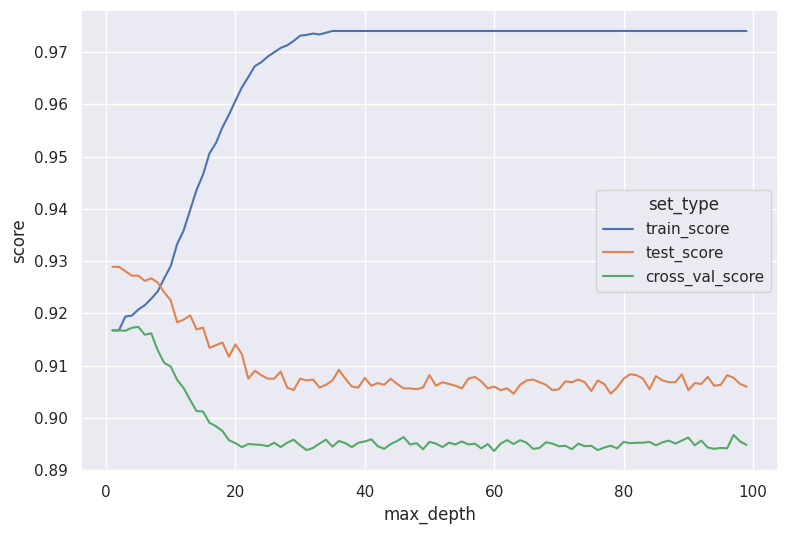

In [110]:
scores_data_long = pd.melt(scores_data, 
                           id_vars = ['max_depth'], 
                           value_vars = ['train_score','test_score', 'cross_val_score'], 
                           var_name = 'set_type', 
                           value_name = 'score')

sns.lineplot(x='max_depth', y='score', hue='set_type', data=scores_data_long)

In [117]:
scores_data_long.query("set_type == 'cross_val_score'").head(10)

,max_depth,set_type,score
198,1,cross_val_score,0.916757
199,2,cross_val_score,0.916757
200,3,cross_val_score,0.916674
201,4,cross_val_score,0.917255
202,5,cross_val_score,0.917421
203,6,cross_val_score,0.915926
204,7,cross_val_score,0.916176
205,8,cross_val_score,0.912939
206,9,cross_val_score,0.910532
207,10,cross_val_score,0.909868


In [118]:
best_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 5)

In [119]:
cross_val_score(best_clf, X_test, y_test, cv=5)

array([0.92929293, 0.92923336, 0.93344566, 0.93007582, 0.92670598])

# GridSearchCV

In [120]:
from sklearn.model_selection import GridSearchCV

In [121]:
clf = tree.DecisionTreeClassifier()

In [170]:
params = {'criterion': ['entropy', 'gini'], 'max_depth': range(1, 30), 'min_samples_split': range(2, 600, 50), 'min_samples_leaf': range(2, 600, 50)}

In [171]:
grid_search_cv_clf = GridSearchCV(clf, params, cv=5)

In [172]:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(1, 30),
                         'min_samples_leaf': range(2, 600, 50),
                         'min_samples_split': range(2, 600, 50)})

In [173]:
grid_search_cv_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'min_samples_leaf': 102,
 'min_samples_split': 2}

In [174]:
best_clf = grid_search_cv_clf.best_estimator_

In [175]:
best_clf.score(X_test, y_test)

0.9316037735849056

In [129]:
from sklearn.metrics import precision_score, recall_score

In [176]:
y_pred = best_clf.predict(X_test)

In [194]:
y_pred = np.where(y_predicted_prob[:, 1] > 0.2, 1, 0)

In [195]:
precision_score(y_test, y_pred)

0.3349206349206349

In [196]:
recall_score(y_test, y_pred)

0.5

In [197]:
y_predicted_prob = best_clf.predict_proba(X_test)

<AxesSubplot: >

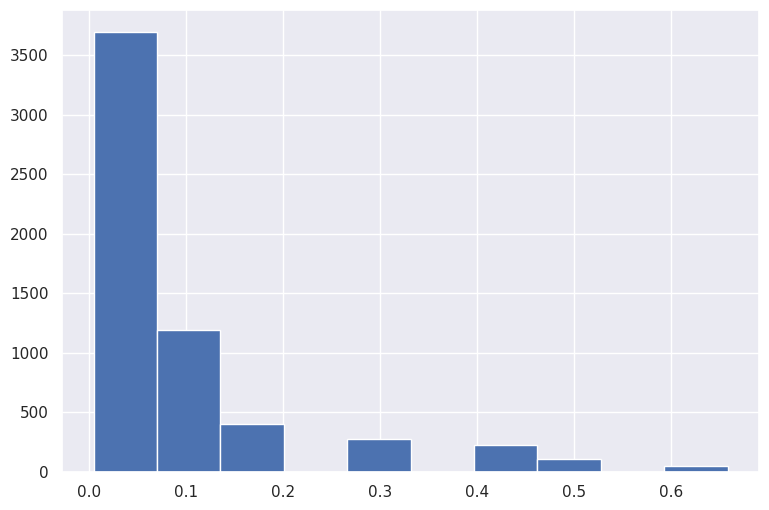

In [199]:
pd.Series(y_predicted_prob[:, 1]).hist()

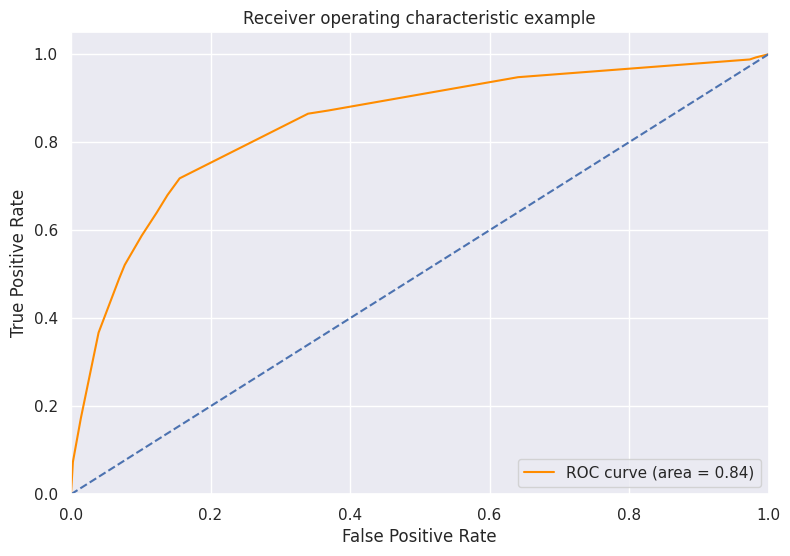

In [200]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Random Forest

In [201]:
from sklearn.ensemble import RandomForestClassifier

In [202]:
clf_rf = RandomForestClassifier()

In [207]:
parameters = {'n_estimators': range(2, 50, 10), 'max_depth': [2, 5, 7, 10], 'min_samples_split': range(2, 600, 50), 'min_samples_leaf': range(2, 600, 50)}

In [208]:
grid_search_cv_clf_rf = GridSearchCV(clf_rf, parameters, cv=5)

In [209]:
grid_search_cv_clf_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 5, 7, 10],
                         'min_samples_leaf': range(2, 600, 50),
                         'min_samples_split': range(2, 600, 50),
                         'n_estimators': range(2, 50, 10)})

In [210]:
grid_search_cv_clf_rf.best_params_

{'max_depth': 7,
 'min_samples_leaf': 102,
 'min_samples_split': 302,
 'n_estimators': 42}

In [211]:
best_clf_rf = grid_search_cv_clf_rf.best_estimator_

In [212]:
best_clf_rf.score(X_test, y_test)

0.9305929919137467

In [213]:
best_clf_rf.feature_importances_

array([0.19585118, 0.36028481, 0.24779217, 0.07101427, 0.03187875,
       0.09317882])

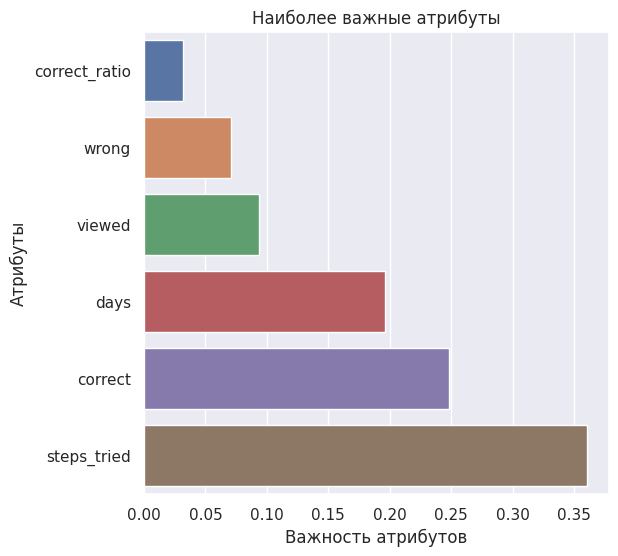

In [217]:
feature_importances_df = pd.DataFrame({'features':list(X_train.columns), 
                                       'feature_importances':  best_clf_rf.feature_importances_})\
                        .sort_values(by='feature_importances')

f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(y=feature_importances_df.features, x=feature_importances_df.feature_importances)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.show()

In [218]:
feature_importances_df.sort_values('feature_importances', ascending=False)

,features,feature_importances
1,steps_tried,0.360285
2,correct,0.247792
0,days,0.195851
5,viewed,0.093179
3,wrong,0.071014
4,correct_ratio,0.031879
